In [2]:
# Cell 1: Imports and Setup
import requests
import json
from dotenv import load_dotenv
import os
import pandas as pd
from datetime import date, datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Load environment variables and setup device
load_dotenv()
ALPHA_VANTAGE_API_KEY = os.getenv('ALPHA_VANTAGE_API_KEY')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Cell 2: Autoencoder Model and Training Functions
class BollingerAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim_factor=0.5):
        super().__init__()
        hidden_dim = int(input_dim * 0.75)
        bottleneck_dim = int(input_dim * encoding_dim_factor)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, bottleneck_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

def create_sequences(data, sequence_length):
    data_tensor = torch.FloatTensor(data.values)
    sequences = []
    for i in range(data_tensor.shape[1]):
        feature_sequences = data_tensor[:, i].unfold(0, sequence_length, 1)
        sequences.append(feature_sequences)
    return torch.stack(sequences, dim=2).numpy()

def train_autoencoder(model, train_data, test_data, epochs=100, batch_size=32):
    train_tensor = torch.FloatTensor(train_data).to(device)
    test_tensor = torch.FloatTensor(test_data).to(device)
    train_loader = DataLoader(TensorDataset(train_tensor, train_tensor), 
                            batch_size=batch_size, shuffle=True)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_x, _ in train_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.6f}')
    
    model.eval()
    with torch.no_grad():
        test_loss = criterion(model(test_tensor), test_tensor)
    print(f'Test Loss: {test_loss.item():.6f}')
    return model

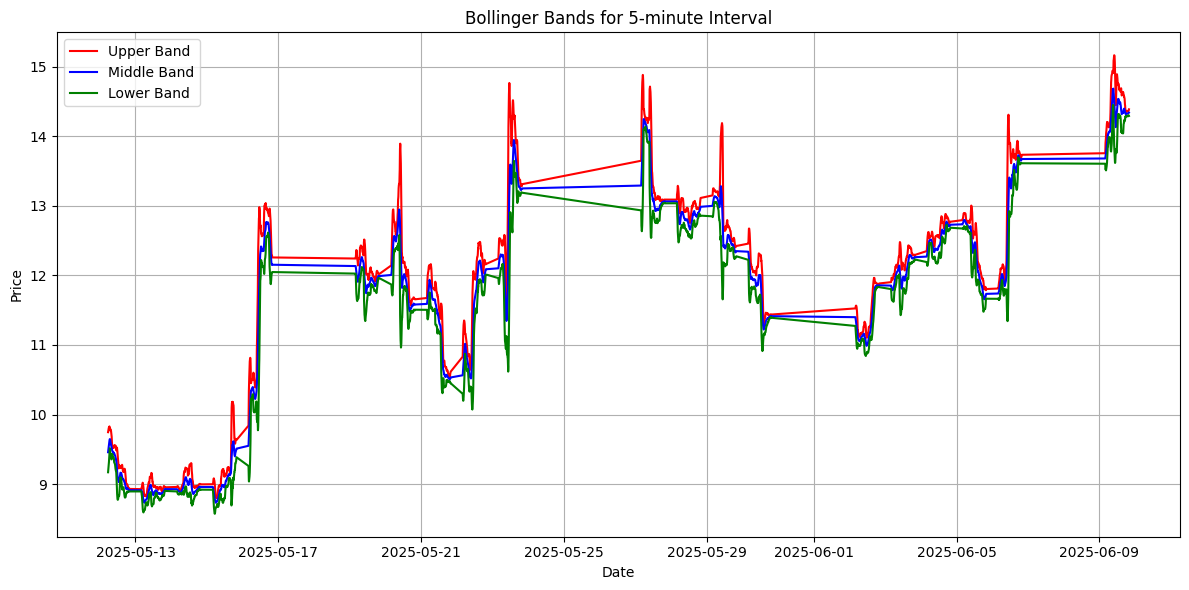

Detected 0 anomalies in 5-minute data


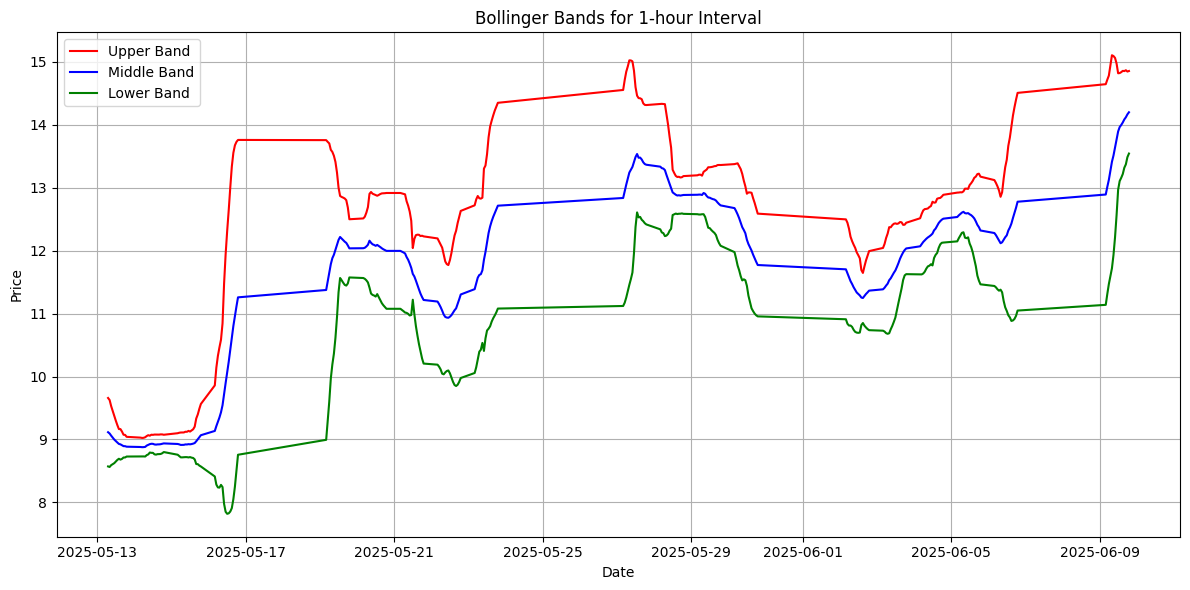

Detected 0 anomalies in 1-hour data


In [5]:
#3
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

# Define your API key (make sure this is defined in a previous cell)
# ALPHA_VANTAGE_API_KEY = "your_api_key_here"

def fetch_and_process_bbands(params, interval_name):
    """
    Fetch Bollinger Bands data from Alpha Vantage API and process it
    """
    response = requests.get("https://www.alphavantage.co/query", params=params)
    data = response.json()
    
    # Check if there's an error message in the response
    if 'Error Message' in data:
        print(f"API Error: {data['Error Message']}")
        return pd.DataFrame()  # Return empty DataFrame
        
    # The correct key for Bollinger Bands data
    if 'Technical Analysis: BBANDS' not in data:
        print(f"Unexpected API response format. Available keys: {list(data.keys())}")
        # Print the first few items to debug
        print(f"Response preview: {str(data)[:500]}...")
        return pd.DataFrame()  # Return empty DataFrame
    
    # Extract the data
    bbands_data = data['Technical Analysis: BBANDS']
    
    # Convert to DataFrame
    df = pd.DataFrame.from_dict(bbands_data, orient='index')
    
    # Convert string values to float
    for col in df.columns:
        df[col] = df[col].astype(float)
    
    # Convert index to datetime
    df.index = pd.to_datetime(df.index)
    
    return df.sort_index()

def visualize_bollinger_bands(df, interval_name):
    """
    Visualize Bollinger Bands for the given dataframe
    """
    plt.figure(figsize=(12, 6))
    
    # Check the column names in the dataframe
    if 'Real Upper Band' in df.columns:
        # Alpha Vantage API standard column names
        plt.plot(df.index, df['Real Upper Band'], 'r-', label='Upper Band')
        plt.plot(df.index, df['Real Middle Band'], 'b-', label='Middle Band')
        plt.plot(df.index, df['Real Lower Band'], 'g-', label='Lower Band')
    else:
        # If columns have different names, print them and use the first three
        print(f"Column names in dataframe: {df.columns.tolist()}")
        cols = df.columns.tolist()
        if len(cols) >= 3:
            plt.plot(df.index, df[cols[0]], 'r-', label='Upper Band')
            plt.plot(df.index, df[cols[1]], 'b-', label='Middle Band')
            plt.plot(df.index, df[cols[2]], 'g-', label='Lower Band')
    
    plt.title(f'Bollinger Bands for {interval_name} Interval')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def detect_anomalies(df, interval_name):
    """
    Detect price anomalies using Bollinger Bands
    """
    anomalies = []
    
    # Check the column names in the dataframe
    if 'Real Upper Band' in df.columns and 'Real Middle Band' in df.columns and 'Real Lower Band' in df.columns:
        # Standard Alpha Vantage column names
        upper_band = df['Real Upper Band']
        middle_band = df['Real Middle Band']
        lower_band = df['Real Lower Band']
    else:
        # If columns have different names, use the first three columns
        cols = df.columns.tolist()
        if len(cols) >= 3:
            upper_band = df[cols[0]]
            middle_band = df[cols[1]]
            lower_band = df[cols[2]]
        else:
            print(f"Not enough columns in dataframe for {interval_name}. Available columns: {cols}")
            return [False] * len(df)
    
    # Calculate price (assuming middle band represents price)
    price = middle_band
    
    # Define anomalies as prices outside the bands
    for i in range(len(df)):
        if price.iloc[i] > upper_band.iloc[i] or price.iloc[i] < lower_band.iloc[i]:
            anomalies.append(True)
            print(f"Anomaly detected at {df.index[i]} in {interval_name} data")
        else:
            anomalies.append(False)
    
    return anomalies

# Main Execution
if __name__ == "__main__":
    SYMBOL = 'QUBT'
    CHART_TITLE = f'Bollinger Bands for {SYMBOL}'
    params_5min = {
        "function": "BBANDS",
        "symbol": SYMBOL,
        "interval": "5min",
        "time_period": "20",
        "series_type": "close",
        "apikey": ALPHA_VANTAGE_API_KEY
    }
    
    params_1hour = {**params_5min, "interval": "60min"}
    
    # Fetch and analyze data
    for interval, params in [("5-minute", params_5min), ("1-hour", params_1hour)]:
        df = fetch_and_process_bbands(params, interval)
        visualize_bollinger_bands(df, interval)
        anomalies = detect_anomalies(df, interval)
        print(f"Detected {sum(anomalies)} anomalies in {interval} data")

In [6]:
# Cell 4: Anomaly Detection Functions
def detect_anomalies(df, interval_name, encoding_dim_factor=0.5, threshold_factor=3.0):
    features = df[['Real Upper Band', 'Real Middle Band', 'Real Lower Band']]
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(features)
    
    train_data, test_data = train_test_split(data_scaled, test_size=0.2, random_state=42)
    model = BollingerAutoencoder(data_scaled.shape[1], encoding_dim_factor).to(device)
    model = train_autoencoder(model, train_data, test_data)
    
    with torch.no_grad():
        reconstructions = model(torch.FloatTensor(data_scaled).to(device)).cpu().numpy()
    mse = np.mean((data_scaled - reconstructions) ** 2, axis=1)
    threshold = np.mean(mse) + threshold_factor * np.std(mse)
    
    plt.figure(figsize=(12, 6))
    plt.plot(mse)
    plt.axhline(threshold, color='r', linestyle='--')
    plt.title(f'Reconstruction Error ({interval_name})')
    plt.show()
    
    return mse > threshold

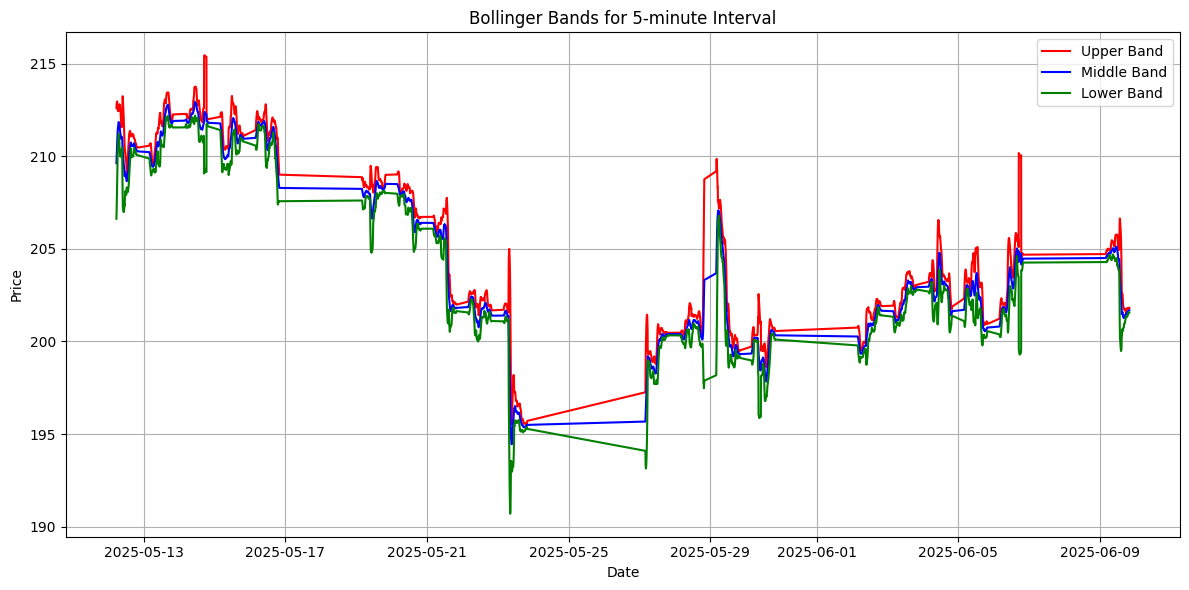

Epoch [10/100], Loss: 0.055116
Epoch [20/100], Loss: 0.055002
Epoch [30/100], Loss: 0.054964
Epoch [40/100], Loss: 0.055002
Epoch [50/100], Loss: 0.054977
Epoch [60/100], Loss: 0.055082
Epoch [70/100], Loss: 0.055010
Epoch [80/100], Loss: 0.055034
Epoch [90/100], Loss: 0.055182
Epoch [100/100], Loss: 0.055163
Test Loss: 0.058032


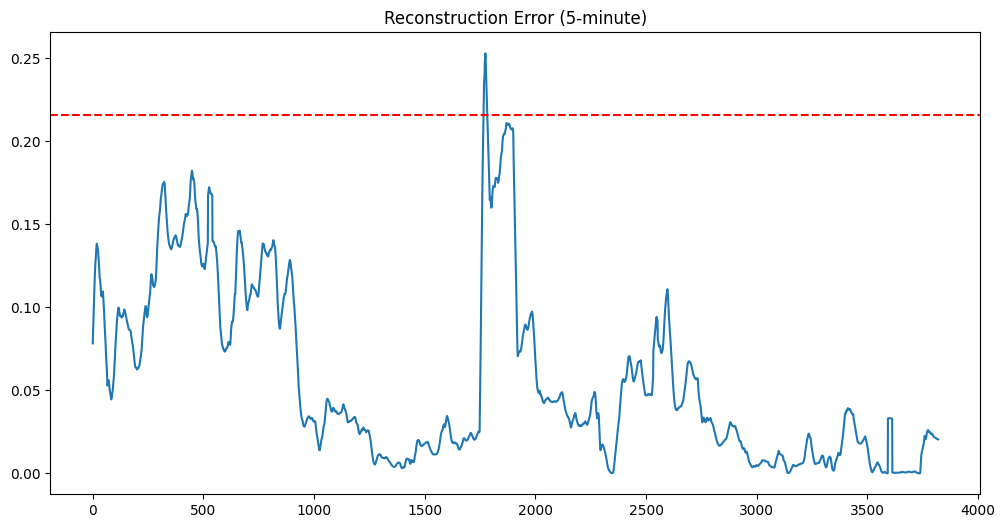

Detected 17 anomalies in 5-minute data


NameError: name 'detect_band_anomalies' is not defined

In [ ]:
# Cell 5: Main Execution
if __name__ == "__main__":
    SYMBOL = 'QUBT'
    params_5min = {
        "function": "BBANDS",
        "symbol": SYMBOL,
        "interval": "5min",
        "time_period": "20",
        "series_type": "close",
        "apikey": ALPHA_VANTAGE_API_KEY
    }
    
    params_1hour = {**params_5min, "interval": "60min"}
    
    # Fetch and analyze data
    for interval, params in [("5-minute", params_5min), ("1-hour", params_1hour)]:
        df = fetch_and_process_bbands(params, interval)
        visualize_bollinger_bands(df, interval)
        anomalies = detect_anomalies(df, interval)
        print(f"Detected {sum(anomalies)} anomalies in {interval} data")
        
        # New band-specific anomaly detection
        band_anomalies = detect_band_anomalies(df, interval)
        print(f"Detected {band_anomalies.sum()} band-specific anomalies in {interval} data")

In [13]:
# Cell 6: Bollinger Band-Specific Anomaly Detection
def detect_band_anomalies(df, interval_name, window=20, threshold_factor=2.0):
    """
    Detect anomalies specific to Bollinger Bands patterns:
    1. Price crossing outside bands
    2. Bandwidth expansion anomalies
    3. %b indicator anomalies
    """
    df = df.copy()
    
    # Calculate %b indicator
    df['%b'] = (df['Real Middle Band'] - df['Real Lower Band']) / \
               (df['Real Upper Band'] - df['Real Lower Band'])
    
    # Calculate bandwidth
    df['Bandwidth'] = df['Real Upper Band'] - df['Real Lower Band']
    
    # 1. Price crossing outside bands (using Middle Band as price proxy)
    df['Above Upper'] = df['Real Middle Band'] > df['Real Upper Band']
    df['Below Lower'] = df['Real Middle Band'] < df['Real Lower Band']
    
    # 2. Bandwidth expansion anomalies
    df['Bandwidth Change'] = df['Bandwidth'].pct_change().abs()
    bandwidth_mean = df['Bandwidth Change'].rolling(window).mean()
    bandwidth_std = df['Bandwidth Change'].rolling(window).std()
    df['Bandwidth Anomaly'] = df['Bandwidth Change'] > (bandwidth_mean + threshold_factor * bandwidth_std)
    
    # 3. %b indicator anomalies
    df['%b Anomaly'] = (df['%b'] > 1.2) | (df['%b'] < -0.2)
    
    # Combine anomalies
    df['Band Anomaly'] = df['Above Upper'] | df['Below Lower'] | df['Bandwidth Anomaly'] | df['%b Anomaly']
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # Price and Bands
    plt.subplot(3, 1, 1)
    plt.plot(df['Real Middle Band'], label='Middle Band')
    plt.plot(df['Real Upper Band'], label='Upper Band', alpha=0.7)
    plt.plot(df['Real Lower Band'], label='Lower Band', alpha=0.7)
    anomalies = df[df['Band Anomaly']]
    plt.scatter(anomalies.index, anomalies['Real Middle Band'], 
                color='red', label='Anomalies', zorder=5)
    plt.title(f'Bollinger Bands with Anomalies ({interval_name})')
    plt.legend()
    
    # Bandwidth Change
    plt.subplot(3, 1, 2)
    plt.plot(df['Bandwidth Change'], label='Bandwidth Change')
    plt.plot(df['Bandwidth Change'].rolling(window).mean(), label='Moving Avg')
    plt.axhline(y=threshold_factor*df['Bandwidth Change'].std(), color='r', linestyle='--')
    plt.title('Bandwidth Change Rate')
    plt.legend()
    
    # %b Indicator
    plt.subplot(3, 1, 3)
    plt.plot(df['%b'], label='%b')
    plt.axhline(y=1, color='g', linestyle='--', label='Upper Threshold')
    plt.axhline(y=0, color='r', linestyle='--', label='Lower Threshold')
    plt.title('%b Indicator')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{SYMBOL}_band_anomalies_{interval_name}.png')
    plt.show()
    
    return df['Band Anomaly']

# Update main execution to include this new detection method


In [9]:
from huggingface_hub import hf_hub_download

checkpoint_path = hf_hub_download(
    repo_id="facebook/sam2.1-hiera-tiny",
    filename="sam2.1_hiera_tiny.pt",
    local_dir="./checkpoints"
)


In [12]:
# CELL 1: Setup and Image Loading
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Initialize predictor with downloaded checkpoint
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Use the locally downloaded checkpoint
checkpoint_path = "./checkpoints/sam2.1_hiera_tiny.pt"

try:
    # Load from local checkpoint instead of from_pretrained
    from sam2.build_sam import build_sam2
    from sam2.sam2_image_predictor import SAM2ImagePredictor
    
    # Build SAM2 model from checkpoint
    sam2_model = build_sam2("sam2.1_hiera_t.yaml", checkpoint_path, device=device)
    predictor = SAM2ImagePredictor(sam2_model)
    print("✓ SAM2 predictor loaded successfully from local checkpoint")
except Exception as e:
    print(f"✗ Error loading predictor from checkpoint: {e}")
    # Fallback to from_pretrained if available
    try:
        predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2.1-hiera-tiny")
        print("✓ SAM2 predictor loaded successfully (fallback)")
    except Exception as e2:
        print(f"✗ Fallback also failed: {e2}")
        predictor = None

# Load and display image
image_path = "/Users/adamaslan/code/ai-fin-opt2/ai-fin3/AAPL_band_anomalies_1-hour.png"

try:
    input_image_pil = Image.open(image_path).convert("RGB")
    input_image_np = np.array(input_image_pil)
    print(f"✓ Image loaded: {image_path}")
    print(f"Image dimensions: {input_image_np.shape}")
    
    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(input_image_pil)
    plt.title("Original Financial Chart - Click coordinates for segmentation")
    plt.axis('on')  # Keep axis to see coordinates
    plt.grid(True, alpha=0.3)
    plt.show()
    
except Exception as e:
    print(f"✗ Error loading image: {e}")
    input_image_pil = None
    input_image_np = None


ModuleNotFoundError: No module named 'sam2.sam2_image_predictor'

In [ ]:
# probz not right work flow - work on

In [13]:

# CELL 1: Setup and Image Loading
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Initialize predictor
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

try:
    predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2.1-hiera-tiny")
    print("✓ SAM2 predictor loaded successfully")
except Exception as e:
    print(f"✗ Error loading predictor: {e}")
    predictor = None

# Load and display image
image_path = "/Users/adamaslan/code/ai-fin-opt2/ai-fin3/AAPL_band_anomalies_1-hour.png"

try:
    input_image_pil = Image.open(image_path).convert("RGB")
    input_image_np = np.array(input_image_pil)
    print(f"✓ Image loaded: {image_path}")
    print(f"Image dimensions: {input_image_np.shape}")
    
    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(input_image_pil)
    plt.title("Original Financial Chart - Click coordinates for segmentation")
    plt.axis('on')  # Keep axis to see coordinates
    plt.grid(True, alpha=0.3)
    plt.show()
    
except Exception as e:
    print(f"✗ Error loading image: {e}")
    input_image_pil = None
    input_image_np = None

ModuleNotFoundError: No module named 'sam2.sam2_image_predictor'

if predictor:
    # 1. Load your image
    # Replace with the actual path to one of your PNG files
    image_path = "/Users/adamaslan/code/ai-fin-opt2/ai-fin3/AAPL_band_anomalies_1-hour.png" 
    try:
        input_image_pil = Image.open(image_path).convert("RGB")
        print(f"Successfully loaded image: {image_path}")
        
        # Convert PIL Image to a NumPy array if needed by set_image, or pass PIL image directly
        # predictor.set_image usually expects a PyTorch tensor in CHW format (Channels, Height, Width)
        # or sometimes a BGR numpy array. Check the specific requirements of SAM2ImagePredictor.set_image.
        # For now, let's assume it can handle a PIL image or we'll adapt it.

    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        input_image_pil = None
    except Exception as e:
        print(f"Error loading image: {e}")
        input_image_pil = None

    if input_image_pil:
        with torch.inference_mode(), torch.autocast(device, dtype=torch.bfloat16 if device != 'cpu' else torch.float32):
            # 2. Set the image in the predictor
            # This might involve preprocessing the PIL image to the format expected by the model
            # (e.g., converting to tensor, normalizing, etc.)
            # The exact preprocessing depends on the SAM2ImagePredictor implementation details.
            # For simplicity, we'll assume set_image can handle a PIL image or a basic numpy array.
            # You may need to consult the SAM2 documentation for precise input format.
            try:
                # Example: Convert PIL to NumPy array (H, W, C)
                # input_image_np = np.array(input_image_pil)
                # predictor.set_image(input_image_np) 
                
                # The `set_image` method in the official SAM/SAM2 examples often takes a BGR numpy array.
                # Let's try to provide it in a way that's commonly used, but you might need to adjust.
                bgr_image = np.array(input_image_pil)[:, :, ::-1] # RGB to BGR
                predictor.set_image(bgr_image)
                print("Image set in predictor.")

                # 3. Define your input prompts (THIS IS THE CRITICAL PART YOU NEED TO CUSTOMIZE)
                # Prompts can be points, boxes, or masks.
                # For Bollinger Band squeezes, you might use bounding boxes.
                # Example: A bounding box [x_min, y_min, x_max, y_max]
                # You'll need to determine these coordinates by inspecting your image.
                # input_prompts = {
                #     "point_coords": None, # e.g., [[[x1, y1], [x2, y2]]]
                #     "point_labels": None, # e.g., [[1, 0]] (1 for foreground, 0 for background)
                #     "box": np.array([[100, 200, 300, 250]]), # Example: [[x_min, y_min, x_max, y_max]]
                #     "mask_input": None
                # }
                
                # Placeholder: You MUST define appropriate prompts for your image and task.
                # For example, to segment a squeeze visually identified at coordinates (x1,y1) to (x2,y2)
                # on the 'AAPL_band_anomalies_1-hour.png' image:
                # You would need to find these pixel coordinates by looking at the image.
                # Let's assume a hypothetical squeeze box for demonstration:
                # This is an EXAMPLE, replace with actual coordinates from your image inspection.
                squeeze_box_example = np.array([[50, 100, 200, 150]]) # [xmin, ymin, xmax, ymax]
                
                input_prompts = {"box": squeeze_box_example}
                print(f"Using example prompt box: {squeeze_box_example}")

                # 4. Make the prediction
                masks, scores, logits = predictor.predict(
                    point_coords=input_prompts.get("point_coords"),
                    point_labels=input_prompts.get("point_labels"),
                    box=input_prompts.get("box"),
                    mask_input=input_prompts.get("mask_input"),
                    multimask_output=True # Get multiple masks if available
                )
                
                print(f"Prediction complete. Number of masks generated: {len(masks)}")
                # masks is a NumPy array of shape (num_masks, height, width)
                # scores is a NumPy array of shape (num_masks,)

                # You can then visualize these masks, e.g., using matplotlib
                # import matplotlib.pyplot as plt
                # for i, mask in enumerate(masks):
                #     plt.figure()
                #     plt.imshow(input_image_pil)
                #     plt.imshow(mask, alpha=0.5, cmap='jet')
                #     plt.title(f"Mask {i+1}, Score: {scores[i]:.2f}")
                #     plt.axis('off')
                # plt.show()

            except Exception as e:
                print(f"Error during prediction: {e}")
else:
    print("Predictor not loaded. Cannot proceed with image processing and prediction.")


In [4]:
from huggingface_hub import HfApi

api = HfApi()
try:
    models = api.list_models()
    print("Hugging Face Hub is working. Found models:", models)
except Exception as e:
    print("Failed to access Hugging Face Hub:", e)


Hugging Face Hub is working. Found models: <generator object HfApi.list_models at 0x111090190>
